In [25]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import sparse
from datetime import datetime
from sklearn import preprocessing
from scipy.stats import skew, boxcox,boxcox_normmax
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


seed = 1234

# Load Data

In [2]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file).reset_index()
test_df = pd.read_json(test_file).reset_index()
ntrain = train_df.shape[0]
print train_df.shape
print test_df.shape
print ntrain

(49352, 16)
(74659, 15)
49352


In [3]:
# sc_price
tmp = pd.concat([train_df['price'],test_df['price']])
ulimit = np.percentile(tmp.values, 99)

train_df.loc[:,'sc_price'] = train_df['price'].values.reshape(-1, 1)
test_df.loc[:,'sc_price'] = test_df['price'].values.reshape(-1, 1)

train_df.loc[train_df['sc_price']>ulimit, ['sc_price']] = ulimit
test_df.loc[test_df['sc_price']>ulimit, ['sc_price']] = ulimit

# sc_ba_price
inx_train = train_df['bathrooms'] == 0
inx_test = test_df['bathrooms'] == 0

non0_inx_train = ~inx_train
non0_inx_test = ~inx_test
train_df.loc[non0_inx_train,'sc_ba_price'] = train_df.loc[non0_inx_train,'sc_price']\
                                                /train_df.loc[non0_inx_train,'bathrooms']
test_df.loc[non0_inx_test,'sc_ba_price'] = test_df.loc[non0_inx_test,'sc_price']\
                                                /test_df.loc[non0_inx_test,'bathrooms']

train_df.loc[inx_train,'sc_ba_price'] = 0
test_df.loc[inx_test,'sc_ba_price'] = 0

# price per bedrooms

inx_train = train_df['bedrooms'] == 0
inx_test = test_df['bedrooms'] == 0

non0_inx_train = ~inx_train
non0_inx_test = ~inx_test
train_df.loc[non0_inx_train,'sc_be_price'] = train_df.loc[non0_inx_train,'sc_price'] \
                                                /train_df.loc[non0_inx_train,'bedrooms']
test_df.loc[non0_inx_test,'sc_be_price'] = test_df.loc[non0_inx_test,'sc_price']\
                                                /test_df.loc[non0_inx_test,'bedrooms']

train_df.loc[inx_train,'sc_be_price'] = 0
test_df.loc[inx_test,'sc_be_price'] = 0


# bathrooms

ulimit = 5

train_df['sc_bathrooms']=train_df['bathrooms']
test_df['sc_bathrooms']=test_df['bathrooms']

train_df.loc[train_df['sc_bathrooms']>ulimit,['sc_bathrooms']] = ulimit
test_df.loc[test_df['sc_bathrooms']>ulimit,['sc_bathrooms']] = ulimit

# bedrooms

ulimit = 8

train_df['sc_bedrooms']=train_df['bedrooms']
test_df['sc_bedrooms']=test_df['bedrooms']

train_df.loc[train_df['sc_bedrooms']>ulimit, ['sc_bedrooms']] = ulimit
test_df.loc[test_df['sc_bedrooms']>ulimit,['sc_bedrooms']] = ulimit

# longitude

tmp = pd.concat([train_df['longitude'],test_df['longitude']])
llimit = np.percentile(tmp.values, 0.1)
ulimit = np.percentile(tmp.values, 99.9)

train_df['sc_longitude']=train_df['longitude']
test_df['sc_longitude']=test_df['longitude']

train_df.loc[train_df['sc_longitude']>ulimit, ['sc_longitude']] = ulimit
test_df.loc[test_df['sc_longitude']>ulimit, ['sc_longitude']] = ulimit
train_df.loc[train_df['sc_longitude']<llimit, ['sc_longitude']] = llimit
test_df.loc[test_df['sc_longitude']<llimit, ['sc_longitude']] = llimit

# latitude

tmp = pd.concat([train_df['latitude'],test_df['latitude']])
llimit = np.percentile(tmp.values, 0.1)
ulimit = np.percentile(tmp.values, 99.9)

train_df['sc_latitude']=train_df['latitude']
test_df['sc_latitude']=test_df['latitude']

train_df.loc[train_df['sc_latitude']>ulimit, ['sc_latitude']] = ulimit
test_df.loc[test_df['sc_latitude']>ulimit, ['sc_latitude']] = ulimit
train_df.loc[train_df['sc_latitude']<llimit, ['sc_latitude']] = llimit
test_df.loc[test_df['sc_latitude']<llimit, ['sc_latitude']] = llimit


features_to_use  = ["sc_bathrooms", "sc_bedrooms", "sc_latitude", "sc_longitude",
                    "sc_price", "sc_ba_price", "sc_be_price"]

In [4]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words", "created_month", 
                        "created_day", "created_hour"])


In [5]:
# full_data=pd.concat([train_df,test_df])

# SSL = preprocessing.StandardScaler()
# for col in features_to_use:
#     full_data[col], lam = boxcox(full_data[col] - full_data[col].min() + 1)
#     full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1)) 
#     train_df[col] = full_data.iloc[:ntrain][col]
#     test_df[col] = full_data.iloc[ntrain][col]

# del full_data

In [6]:
features_to_use.append("listing_id")
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [7]:
train_df['features'] = train_df["features"]\
                        .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))\
                        .apply(lambda x: x.lower())
test_df['features'] = test_df["features"]\
                        .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))\
                        .apply(lambda x: x.lower())

print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

sparse_features = tfidf.get_feature_names()

0                                                     
1    doorman elevator fitness_center cats_allowed d...
2    laundry_in_building dishwasher hardwood_floors...
3                               hardwood_floors no_fee
4                                              pre-war
Name: features, dtype: object


In [8]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
weight_num_map = {'high':1, 'medium':1, 'low':1}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
W_train = np.array(train_df['interest_level'].apply(lambda x: weight_num_map[x]))

all_features = features_to_use + sparse_features
print train_X.shape, test_X.shape

(49352, 218) (74659, 218)


In [9]:
# cv_dataset = xgb.DMatrix(train_X, label = train_y,
#                          weight = W_train,
#                          feature_names = all_features)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.90, random_state=1234)
print X_train.shape
print X_val.shape
# xgtrain = xgb.DMatrix(X_train, label=y_train)

(44416, 218)
(4936, 218)


In [11]:
# rgr = xgb.XGBClassifier(objective = 'multi:softprob',
#                        learning_rate = 0.1,
#                        n_estimators = 10000,
#                        nthread = -1)

# rgr.fit(X_train,y_train,
#         eval_set=[(X_val,y_val)],
#         eval_metric='mlogloss',
# #         num_class = 3,
#         early_stopping_rounds=20,
#         verbose=False
#        )

# tmp1 = rgr.predict_proba(test_X)
# tmp1=pd.DataFrame(tmp1)
# tmp1.columns = ['high','medium','low']
# plt.scatter(range(74659),tmp1.high)

In [28]:
learning_rate = 0.1
best_score = 1000
train_param = 0
for x in [3,4,5,6,7,8,9,10]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= x,
        nthread = -1,
        silent = False
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x

    print x, '\t', rgr.best_score

3 	0.556399
4 	0.556165
5 	0.553328
6 	0.552869
7 	0.557626
8 	0.556641
9 	0.559613
10 	0.562173


In [29]:
max_depth = train_param
print train_param
# 3 	0.550966
# 4 	0.546335
# 5 	0.546948
# 6 	0.548233
# 7 	0.548868
# 8 	0.551074
# 9 	0.553485
# 10 	0.557234

In [31]:
best_score = 1000
train_param = 0
for x in [5,10,20,50,80,120,180,240,300]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score

5 	0.552672
10 	0.552702
20 	0.554569
50 	0.555714
80 	0.558212
120 	0.556721
180 	0.556979
240 	0.563283
300 	0.565675


In [33]:
min_child_weight = train_param
print min_child_weight

5


In [34]:
best_score = 1000
train_param = 0
for x in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=False
    )

    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score

0.3 	0.544995
0.4 	0.548923
0.5 	0.547074
0.6 	0.546579
0.7 	0.551113
0.8 	0.550493
0.9 	0.551921


In [37]:
colsample_bytree = 0.6
print train_param

0.3


In [38]:
best_score = 1000
train_param = 0
for x in [0.5,0.6,0.7,0.8,0.9]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = colsample_bytree,
        subsample = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=False
    )
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score

0.5 	0.551334
0.6 	0.55245
0.7 	0.54911
0.8 	0.550137
0.9 	0.548913


In [39]:
subsample = train_param
print train_param

0.9


In [40]:
best_score = 1000
train_param = 0
for x in [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = colsample_bytree,
        subsample = subsample,
        gamma = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=False
    )

    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score

0 	0.548913
0.3 	0.549075
0.6 	0.547017
0.9 	0.546771
1.2 	0.549405
1.5 	0.546167
1.8 	0.548024
2.1 	0.548317
2.4 	0.546834
2.7 	0.549393
3.0 	0.545459


In [41]:
gamma = train_param
print train_param

3.0


In [42]:
xgtrain = xgb.DMatrix(train_X, label=train_y) 

def xgb_evaluate(min_child_weight, colsample_bytree, max_depth, subsample, gamma):
    params = dict()
    params['objective']='multi:softprob'
    params['eval_metric']='mlogloss',
    params['num_class']=3
    params['silent']=1
    params['eta'] = 0.1
    params['verbose_eval'] = True
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    
    cv_result = xgb.cv(
        params, xgtrain, 
        num_boost_round=10000, nfold=10,
        metrics = 'mlogloss',
        seed=seed,callbacks=[xgb.callback.early_stop(50)]
    )
    
    return -cv_result['test-mlogloss-mean'].values[-1]


xgb_BO = BayesianOptimization(
    xgb_evaluate, 
    {
        'max_depth': (3,6),
        'min_child_weight': (1,50),
        'colsample_bytree': (0.7,1),
        'subsample': (0.7,1),
        'gamma': (0.3,2.1)
    }
)

xgb_BO.maximize(init_points=10, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1093]	train-mlogloss:0.401341+0.00132894	test-mlogloss:0.542346+0.00573164

    1 | 08m25s |   -0.54235 |             0.8668 |    1.9502 |      4.7133 |             2.6959 |      0.8435 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[566]	train-mlogloss:0.420788+0.00165193	test-mlogloss:0.547142+0.00599595

    2 | 05m31s |   -0.54714 |             0.8646 |    0.3752 |      5.0573 |            39.3628 |      0.7776 | 
Multiple eval metrics have 

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/bayes_opt/helpers.py:95: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   11 | 07m58s |   -0.54468 |             0.9993 |    0.5129 |      4.0034 |             2.0828 |      0.8933 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1153]	train-mlogloss:0.407059+0.00179506	test-mlogloss:0.54332+0.00567749



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.30528409e-05]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00028024]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.26466873e-05]), 'nit': 6, 'funcalls': 49}
  " state: %s" % convergence_dict)


   12 | 08m23s |   -0.54332 |             0.7552 |    2.0722 |      4.9775 |             7.0850 |      0.8323 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[587]	train-mlogloss:0.377684+0.00163147	test-mlogloss:0.544077+0.00571811

   13 | 05m32s |   -0.54408 |             0.7474 |    1.3964 |      5.3378 |             2.3705 |      0.7276 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[2063]	train-mlogloss:0.420522+0.00145732	test-mlogloss:0.54445+0.00571767



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00010604]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)


   14 | 12m13s |   -0.54445 |             0.8287 |    1.9510 |      3.8450 |             2.0672 |      0.8212 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1380]	train-mlogloss:0.454491+0.00136536	test-mlogloss:0.549283+0.00592362



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00033041]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)


   15 | 08m33s |   -0.54928 |             0.8541 |    0.5258 |      3.0379 |            46.5676 |      0.8193 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[642]	train-mlogloss:0.38395+0.00211097	test-mlogloss:0.545517+0.00634387

   16 | 05m55s |   -0.54552 |             0.7739 |    0.6402 |      5.7887 |             7.8536 |      0.9899 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[962]	train-mlogloss:0.400896+0.00119462	test-mlogloss:0.54542+0.00588859

   17 | 08m32s |   -0.54542 |             0.9962 |    1.9861 |      4.1640 |             3.6469 |      0.7160 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stoppi

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00016017]), 'nit': 6, 'funcalls': 62}
  " state: %s" % convergence_dict)


   22 | 05m40s |   -0.54607 |             0.7401 |    0.7955 |      5.6141 |            19.4741 |      0.7050 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[744]	train-mlogloss:0.384721+0.00152581	test-mlogloss:0.543492+0.00623367

   23 | 07m05s |   -0.54349 |             0.7787 |    2.0531 |      5.2944 |             6.4305 |      0.7946 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[883]	train-mlogloss:0.414706+0.000975753	test-mlogloss:0.545368+0.00585206

   24 | 07m04s |   -0.54537 |             0.8570 |    0.7085 |      4.1269 |            16.1609 |      0.9140 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Sto

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00029022]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.00588069e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


   30 | 06m29s |   -0.54541 |             0.7716 |    1.8068 |      5.8513 |            30.7775 |      0.7993 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1502]	train-mlogloss:0.445836+0.00144625	test-mlogloss:0.54758+0.00574224

   31 | 08m50s |   -0.54758 |             0.7966 |    1.4983 |      3.5242 |            28.6523 |      0.7825 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1763]	train-mlogloss:0.426849+0.00122329	test-mlogloss:0.545375+0.00575754

   32 | 11m55s |   -0.54538 |             0.7091 |    1.5837 |      3.6244 |             8.1661 |      0.8457 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Sto

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.21109546e-05]), 'nit': 4, 'funcalls': 54}
  " state: %s" % convergence_dict)


   33 | 10m05s |   -0.54664 |             0.8338 |    0.6415 |      3.6306 |            18.9455 |      0.8684 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1701]	train-mlogloss:0.444753+0.00124344	test-mlogloss:0.546655+0.00574181



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.81156142e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


   34 | 09m20s |   -0.54665 |             0.7142 |    1.6389 |      3.1005 |            24.5330 |      0.8899 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1491]	train-mlogloss:0.452802+0.00108144	test-mlogloss:0.54934+0.00599488



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.83255179e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


   35 | 09m18s |   -0.54934 |             0.8792 |    1.6112 |      3.0527 |            42.9291 |      0.7541 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[884]	train-mlogloss:0.402449+0.0015482	test-mlogloss:0.545158+0.00689407

   36 | 07m17s |   -0.54516 |             0.9046 |    0.3665 |      4.6079 |             5.7827 |      0.9339 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1518]	train-mlogloss:0.429723+0.00119856	test-mlogloss:0.546094+0.00582152

   37 | 09m33s |   -0.54609 |             0.9016 |    0.7308 |      3.1628 |            12.6465 |      0.8824 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stop

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00014088]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)


   38 | 09m09s |   -0.54585 |             0.7854 |    1.6182 |      3.4167 |            13.7739 |      0.8322 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[732]	train-mlogloss:0.450238+0.0010233	test-mlogloss:0.549448+0.00548907

   39 | 05m38s |   -0.54945 |             0.7964 |    0.5751 |      4.9842 |            44.9441 |      0.7086 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1147]	train-mlogloss:0.415803+0.00220998	test-mlogloss:0.545731+0.00633034

   40 | 09m36s |   -0.54573 |             0.7258 |    1.9244 |      5.7463 |            46.7330 |      0.9780 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stop

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00019838]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00015251]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


   45 | 09m10s |   -0.54816 |             0.8511 |    1.7619 |      3.7501 |            38.0995 |      0.7443 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[603]	train-mlogloss:0.421017+0.00124178	test-mlogloss:0.547274+0.00539585



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00156888]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


   46 | 05m30s |   -0.54727 |             0.7354 |    1.4790 |      5.6728 |            34.0076 |      0.7098 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[788]	train-mlogloss:0.416902+0.00171272	test-mlogloss:0.546026+0.00653838



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00232891]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)
/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00010399]), 'nit': 7, 'funcalls': 65}
  " state: %s" % convergence_dict)


   47 | 08m04s |   -0.54603 |             0.7913 |    2.0545 |      5.5018 |            39.8571 |      0.8385 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[1046]	train-mlogloss:0.425592+0.00155637	test-mlogloss:0.546166+0.00545797

   48 | 11m04s |   -0.54617 |             0.7892 |    2.0132 |      4.8927 |            26.4855 |      0.7682 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[629]	train-mlogloss:0.390545+0.00148152	test-mlogloss:0.545658+0.00690329



/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00094195]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)


   49 | 09m36s |   -0.54566 |             0.9852 |    0.3648 |      5.9029 |            22.6354 |      0.8157 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[897]	train-mlogloss:0.420927+0.00130185	test-mlogloss:0.546387+0.00584617

   50 | 07m26s |   -0.54639 |             0.8990 |    0.4912 |      4.2103 |            30.6949 |      0.8513 | 


In [43]:
xgb_bo_scores = pd.DataFrame([[s[0]['max_depth'],
                               s[0]['min_child_weight'],
                               s[0]['colsample_bytree'],
                               s[0]['subsample'],
                               s[0]['gamma'],
                               s[1]] for s in zip(xgb_BO.res['all']['params'],xgb_BO.res['all']['values'])],
                            columns = ['max_depth',
                                       'min_child_weight',
                                       'colsample_bytree',
                                       'subsample',
                                       'gamma',
                                       'score'])
xgb_bo_scores=xgb_bo_scores.sort_values('score',ascending=False)
xgb_bo_scores.head(10)

,max_depth,min_child_weight,colsample_bytree,subsample,gamma,score
1,4.977517,7.085047,0.755216,0.832299,2.072250,-0.543320
12,5.294358,6.430458,0.778670,0.794628,2.053074,-0.543492
10,4.831209,1.988818,0.976038,0.791368,1.601972,-0.543742
2,5.337825,2.370541,0.747375,0.727643,1.396417,-0.544077
3,3.844964,2.067151,0.828660,0.821156,1.951036,-0.544450
0,4.003396,2.082787,0.999265,0.893346,0.512947,-0.544678
25,4.607936,5.782687,0.904582,0.933866,0.366536,-0.545158
17,5.319597,25.284915,0.932358,0.949350,2.065272,-0.545291
13,4.126909,16.160868,0.857025,0.913964,0.708522,-0.545368
21,3.624415,8.166120,0.709067,0.845712,1.583732,-0.545375


In [9]:
def xgb_blend(estimators, train_x, train_y, test_x, fold, early_stopping_rounds=0):
    N_params = len(estimators)
    print ("Blend %d estimators for %d folds" % (N_params, fold))
    skf = KFold(n_splits=fold,random_state=seed)
    N_class = len(set(train_y))
        
    train_blend_x = np.zeros((train_x.shape[0], N_class*N_params))
    test_blend_x = np.zeros((test_x.shape[0], N_class*N_params))
    scores = np.zeros ((fold,N_params))
    best_rounds = np.zeros ((fold, N_params))
    
    for j, est in enumerate(estimators):
        est.set_params(objective = 'multi:softprob')
        est.set_params(silent = False)
        est.set_params(learning_rate = 0.03)
        est.set_params(n_estimators=100000)
        
        print ("Model %d: %s" %(j+1, est))

        test_blend_x_j = np.zeros((test_x.shape[0], N_class*fold))
    
        for i, (train_index, val_index) in enumerate(skf.split(train_x)):
            print ("Model %d fold %d" %(j+1,i+1))
            fold_start = time.time() 
            train_x_fold = train_x[train_index]
            train_y_fold = train_y[train_index]
            val_x_fold = train_x[val_index]
            val_y_fold = train_y[val_index]   

            est.fit(train_x_fold,train_y_fold,
                    eval_set = [(val_x_fold, val_y_fold)],
                    eval_metric = 'mlogloss',
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=False)
            best_round=est.best_iteration
            best_rounds[i,j]=best_round
            print ("best round %d" % (best_round))
            val_y_predict_fold = est.predict_proba(val_x_fold,ntree_limit=best_round)
            score = log_loss(val_y_fold, val_y_predict_fold)
            print ("Score: ", score)
            scores[i,j]=score
            train_blend_x[val_index, (j*N_class):(j+1)*N_class] = val_y_predict_fold
            
            test_blend_x_j[:,(i*N_class):(i+1)*N_class] = est.predict_proba(test_x,ntree_limit=best_round)
            print ("Model %d fold %d fitting finished in %0.3fs" % (j+1,i+1, time.time() - fold_start))
            
        test_blend_x[:,(j*N_class):(j+1)*N_class] = \
                np.stack([test_blend_x_j[:,range(0,N_class*fold,N_class)].mean(1),
                          test_blend_x_j[:,range(1,N_class*fold,N_class)].mean(1),
                          test_blend_x_j[:,range(2,N_class*fold,N_class)].mean(1)]).T
        print ("Score for model %d is %f" % (j+1,np.mean(scores[:,j])))
    print ("Score for blended models is %f" % (np.mean(scores)))
    return (train_blend_x, test_blend_x, scores,best_rounds,test_blend_x_j)


In [10]:
estimators = [xgb.XGBClassifier(max_depth = 6,
                              min_child_weight = 5,
                              colsample_bytree = 0.6,
                              subsample = 0.9,
                              gamma = 3),
#              xgb.XGBClassifier(max_depth = 5,
#                               min_child_weight = 6,
#                               colsample_bytree = 0.778670,
#                               subsample = 0.794628,
#                               gamma = 2.053074)
             ]





# xgb_params = [{'max_depth':6,
#                'min_child_weight':5,
#                'colsample_bytree':0.6,
#                'subsample':0.9,
#                'gamma':3},
# #               score -0.543320        
#               {'max_depth':5,
#                'min_child_weight':6,
#                'colsample_bytree':0.778670,
#                'subsample':0.794628,
#                'gamma':2.053074},
#               score -0.543492
#               {'max_depth':4,
#                'min_child_weight':1,
#                'colsample_bytree':0.976038,
#                'subsample':0.791368,
#                'gamma':1.601972},
# #               score -0.543742  
#               {'max_depth':5,
#                'min_child_weight':2,
#                'colsample_bytree':0.747375,
#                'subsample':0.727643,
#                'gamma':1.396417},
# #               score -0.544077      
#               {'max_depth':3,
#                'min_child_weight':2,
#                'colsample_bytree':0.828660,
#                'subsample':0.821156,
#                'gamma':1.951036}
# #               score -0.544450
#              ]

(train_blend_x_xgb,
 test_blend_x_xgb,
 blend_scores_xgb,
 best_rounds_xgb,tmp) = xgb_blend(estimators,
                              train_X,train_y,
                              test_X,
                              10,
                              300)

# print (np.mean(blend_scores_xgb_le,axis=0))
# print (np.mean(best_rounds_xgb_le,axis=0))

Blend 1 estimators for 10 folds
Model 1: XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=3, learning_rate=0.03, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.9)
Model 1 fold 1
best round 4905
('Score: ', 0.54247337742848956)
Model 1 fold 1 fitting finished in 676.769s
Model 1 fold 2
best round 3350
('Score: ', 0.53380446733242892)
Model 1 fold 2 fitting finished in 477.740s
Model 1 fold 3
best round 5665
('Score: ', 0.51841402729840236)
Model 1 fold 3 fitting finished in 778.781s
Model 1 fold 4
best round 4150
('Score: ', 0.53219100574651057)
Model 1 fold 4 fitting finished in 576.468s
Model 1 fold 5
best round 3523
('Score: ', 0.52547553537656211)
Model 1 fold 5 fitting finished in 492.912s
Model 1 fold 6
best round 4176
('Score: ', 0.53556574616785135)
Model 1 fold 6 

In [128]:
pd.DataFrame(tmp).head(20)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.044566,0.460453,0.494981,0.046104,0.486853,0.467042,0.052239,0.451836,0.495925,0.060600,...,0.529387,0.054692,0.491957,0.453351,0.065767,0.526081,0.408152,0.042964,0.517221,0.439816
1,0.004466,0.036788,0.958746,0.002629,0.030283,0.967088,0.003106,0.026766,0.970128,0.004504,...,0.961575,0.004076,0.036145,0.959779,0.003172,0.036037,0.960791,0.002761,0.033128,0.964111
2,0.088891,0.428814,0.482295,0.083227,0.433731,0.483042,0.097146,0.453983,0.448872,0.112520,...,0.506227,0.080920,0.441123,0.477956,0.090725,0.442763,0.466512,0.064595,0.452286,0.483119
3,0.119714,0.510923,0.369363,0.121739,0.496122,0.382139,0.109134,0.482848,0.408018,0.180610,...,0.456661,0.094824,0.473570,0.431606,0.129832,0.507627,0.362541,0.107976,0.523689,0.368335
4,0.246655,0.522666,0.230679,0.170953,0.618990,0.210057,0.254950,0.569017,0.176034,0.222274,...,0.179533,0.269260,0.548265,0.182475,0.250829,0.560539,0.188633,0.211703,0.554986,0.233311
5,0.160027,0.495432,0.344541,0.139873,0.486927,0.373200,0.124840,0.460282,0.414879,0.167588,...,0.371646,0.153144,0.486861,0.359995,0.151369,0.547396,0.301234,0.153448,0.461628,0.384924
6,0.022687,0.311935,0.665378,0.026476,0.368393,0.605131,0.021898,0.297906,0.680196,0.031636,...,0.707958,0.021832,0.340147,0.638020,0.024242,0.349858,0.625900,0.021646,0.308829,0.669524
7,0.003949,0.065749,0.930302,0.003851,0.054972,0.941177,0.001837,0.039236,0.958927,0.005270,...,0.940611,0.004755,0.071063,0.924182,0.003687,0.055730,0.940583,0.002435,0.043978,0.953587
8,0.028745,0.383771,0.587485,0.031779,0.408973,0.559248,0.026125,0.392499,0.581376,0.027558,...,0.634928,0.025109,0.355646,0.619245,0.026475,0.336836,0.636689,0.027231,0.320358,0.652411
9,0.054284,0.544205,0.401512,0.071739,0.575213,0.353048,0.062840,0.585746,0.351414,0.081150,...,0.405106,0.064905,0.599840,0.335255,0.062128,0.563416,0.374456,0.044447,0.597871,0.357682


In [129]:
pd.DataFrame(test_blend_x_xgb).head(20)

,0,1,2
0,0.050689,0.479141,0.470170
1,0.003556,0.034600,0.961845
2,0.091907,0.430084,0.478010
3,0.118784,0.504385,0.376830
4,0.243760,0.551849,0.204390
5,0.149103,0.478667,0.372229
6,0.024415,0.330223,0.645363
7,0.003765,0.057998,0.938237
8,0.027641,0.359416,0.612943
9,0.062964,0.562003,0.375033


In [111]:
pd.DataFrame(np.stack([tmp[:,range(0,30,3)].mean(1),tmp[:,range(1,30,3)].mean(1),tmp[:,range(2,30,3)].mean(1)]).T)

,0,1,2
0,0.072210,0.258895,0.668895
1,0.046046,0.074063,0.879891
2,0.105463,0.350333,0.544204
3,0.078242,0.275522,0.646236
4,0.124018,0.367762,0.508220
5,0.107140,0.374264,0.518595
6,0.071425,0.259383,0.669192
7,0.050132,0.104337,0.845532
8,0.070318,0.256687,0.672995
9,0.071713,0.260442,0.667845


In [22]:
now = datetime.now()

name_train_blend = '../output/train_blend_xgb_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
name_test_blend = '../output/test_blend_xgb_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'



print (np.mean(blend_scores_xgb,axis=0))
print (np.mean(best_rounds_xgb,axis=0))
np.savetxt(name_train_blend,train_blend_x_xgb, delimiter=",")
np.savetxt(name_test_blend,test_blend_x_xgb, delimiter=",")

[ 0.54393943  0.54340168  0.54486921  0.54463413  0.5455042 ]
4024.2


In [130]:
test_blend_x_xgb[:,:3]


array([[ 0.05068891,  0.47914108,  0.47017003],
       [ 0.00355554,  0.03459964,  0.96184484],
       [ 0.09190651,  0.43008367,  0.47800982],
       ..., 
       [ 0.04040814,  0.38965375,  0.5699381 ],
       [ 0.06617295,  0.5109495 ,  0.42287757],
       [ 0.0445355 ,  0.33600247,  0.61946204]])

In [11]:
now = datetime.now()
sub_name = '../output/sub_XGB_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'

out_df = pd.DataFrame(test_blend_x_xgb[:,:3])
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv(sub_name, index=False)


# ypreds.columns = cols

# df = pd.read_json(open("../input/test.json", "r"))
# ypreds['listing_id'] = df["listing_id"]

# ypreds.to_csv('my_preds.csv', index=None)

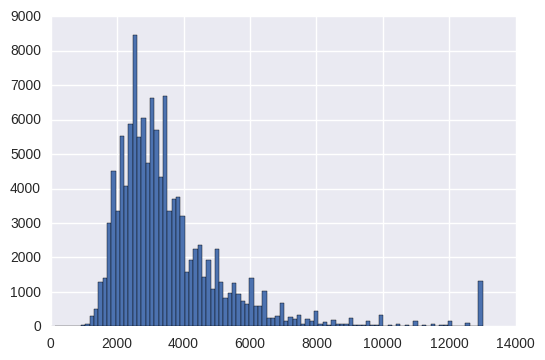

In [45]:
# full_data=pd.concat([train_df,test_df])

# SSL = preprocessing.StandardScaler()
# for col in features_to_use:
#     full_data[col], lam = boxcox(full_data[col] - full_data[col].min() + 1)
#     full_data[col] = SSL.fit_transform(full_data[col].values.reshape(-1,1)) 
#     train_df[col] = full_data.iloc[:ntrain][col]
#     test_df[col] = full_data.iloc[ntrain][col]

# del full_data
full_data=pd.concat([train_df,test_df])
SSL = preprocessing.StandardScaler()
full_data['sc_price'].hist(bins =100)

0.0 15.7866149428


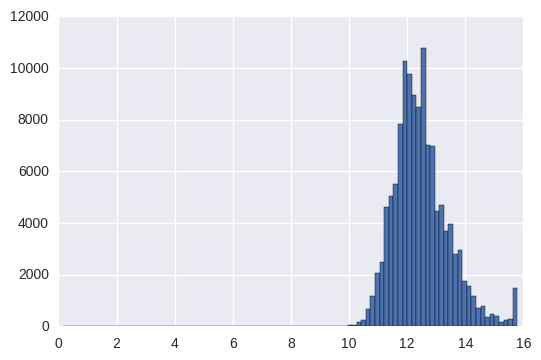

In [61]:
full_data['tmpbox'] = 0
full_data['tmpbox'] = boxcox(full_data['sc_price'],lmbda=0.1)
fig = plt.hist(full_data.tmpbox,bins =100)
print full_data.tmpbox.min(), full_data.tmpbox.max()

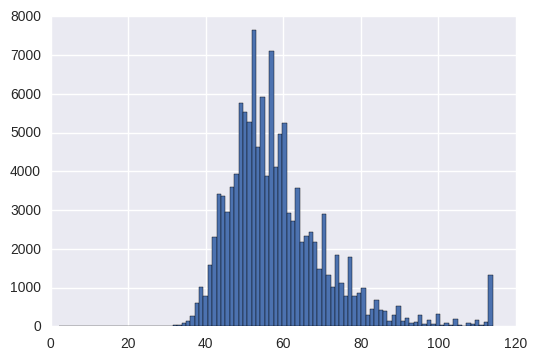

In [55]:
# full_data['tmpstd'] = 0
# full_data['tmpstd'] = SSL.fit_transform(full_data['sc_price'].values.reshape(-1,1)) 
fig = plt.hist(np.sqrt(full_data['sc_price']),bins = 100)